# Supervised Learning - part 1

- Looking for the best model.

In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

from sklearn import naive_bayes, svm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, make_scorer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from imblearn.over_sampling import RandomOverSampler

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
RANDOM_STATE = 42

In [4]:
lemmas = pd.read_csv('../data/lemmas.csv')
lemmas

,book_poem_id,lemmas
0,1_0001-0000-0000-0001-0000,"[('tvůj', 'P'), ('loď', 'N'), ('jít', 'V'), ('..."
1,1_0001-0001-0000-0001-0000,"[('už', 'D'), ('míza', 'N'), ('naplňovat', 'V'..."
2,1_0001-0001-0000-0002-0000,"[('už', 'D'), ('jaro', 'N'), ('výskat', 'V'), ..."
3,1_0001-0001-0000-0003-0000,"[('teď', 'D'), ('slunce', 'N'), ('projít', 'V'..."
4,1_0001-0001-0000-0004-0000,"[('skála', 'N'), ('nebetyčný', 'A'), ('shluk',..."
...,...,...
66423,1689_0001-0000-0000-0026-0000,"[('u', 'R'), ('altán', 'N'), ('bílý', 'A'), ('..."
66424,1689_0001-0000-0000-0027-0000,"[('nad', 'R'), ('tůně', 'N'), ('honit', 'V'), ..."
66425,1689_0001-0000-0000-0028-0000,"[('podle', 'R'), ('cesta', 'N'), ('hloh', 'N')..."
66426,1689_0001-0000-0000-0029-0000,"[('na', 'R'), ('lesní', 'A'), ('stráň', 'N'), ..."


In [7]:
annotations = pd.read_csv('../data/poem_value_save.csv')
annotations

,book_poem_id,poem_id,book_id,id_topic,value,name
0,2_0001-0000-0000-0005-0000,0001-0000-0000-0005-0000,2,1,-1,Dětství/mateřství/rodičovství
1,2_0001-0000-0000-0005-0000,0001-0000-0000-0005-0000,2,2,-1,Domov
2,2_0001-0000-0000-0005-0000,0001-0000-0000-0005-0000,2,3,-1,Exotika/cestovatelství
3,2_0001-0000-0000-0005-0000,0001-0000-0000-0005-0000,2,4,-1,Chudoba/útisk
4,2_0001-0000-0000-0005-0000,0001-0000-0000-0005-0000,2,9,-1,Náboženství/víra
...,...,...,...,...,...,...
27154,1675_0001-0009-0000-0015-0002,0001-0009-0000-0015-0002,1675,26,-1,Město
27155,1675_0001-0009-0000-0015-0002,0001-0009-0000-0015-0002,1675,27,-1,Venkov
27156,1675_0001-0009-0000-0015-0002,0001-0009-0000-0015-0002,1675,28,-1,Národ/vlast
27157,1675_0001-0009-0000-0015-0002,0001-0009-0000-0015-0002,1675,29,-1,Historie


In [8]:
annotations_1 = annotations[annotations.value == 1].reset_index(drop=True)
annotations_1

,book_poem_id,poem_id,book_id,id_topic,value,name
0,2_0001-0000-0000-0005-0000,0001-0000-0000-0005-0000,2,13,1,Práce
1,2_0001-0000-0000-0008-0000,0001-0000-0000-0008-0000,2,9,1,Náboženství/víra
2,3_0001-0003-0000-0012-0000,0001-0003-0000-0012-0000,3,9,1,Náboženství/víra
3,7_0001-0000-0000-0065-0000,0001-0000-0000-0065-0000,7,20,1,"Umění/literatura, poezie/tvorba"
4,8_0001-0000-0000-0004-0000,0001-0000-0000-0004-0000,8,30,1,Sebereflexe/vnitřní život
...,...,...,...,...,...,...
917,1675_0001-0005-0000-0028-0000,0001-0005-0000-0028-0000,1675,14,1,Příroda
918,1675_0001-0005-0000-0042-0000,0001-0005-0000-0042-0000,1675,30,1,Sebereflexe/vnitřní život
919,1675_0001-0007-0001-0003-0000,0001-0007-0001-0003-0000,1675,12,1,Politika/společnost
920,1675_0001-0007-0001-0003-0000,0001-0007-0001-0003-0000,1675,26,1,Město


In [9]:
annotations_1.name.value_counts()

Láska/milostný vztah               171
Sebereflexe/vnitřní život          111
Příroda                             85
Náboženství/víra                    85
Smrt/umírání/stáří                  77
Umění/literatura, poezie/tvorba     64
Politika/společnost                 64
Národ/vlast                         51
Samota/odcizení                     37
Historie                            32
Dětství/mateřství/rodičovství       29
Práce                               16
Chudoba/útisk                       16
Domov                               15
Město                               13
Zločin/trest                         9
Tradice/folklor                      9
Válka                                8
Zábava/volný čas                     8
Revoluce/Osvobození                  8
Exotika/cestovatelství               4
Vzdělání/škola                       4
Venkov                               4
Tělo/sport                           2
Name: name, dtype: int64

In [7]:
annotations_lemmas = pd.merge(annotations_1, lemmas, on='book_poem_id', how='left')
annotations_lemmas

,book_poem_id,poem_id,book_id,id_topic,value,name,lemmas
0,2_0001-0000-0000-0005-0000,0001-0000-0000-0005-0000,2,13,1,Práce,"[('chuť', 'N'), ('k', 'R'), ('práce', 'N'), ('..."
1,2_0001-0000-0000-0008-0000,0001-0000-0000-0008-0000,2,9,1,Náboženství/víra,"[('truchlit', 'V'), ('když', 'J'), ('rána', 'N..."
2,3_0001-0003-0000-0012-0000,0001-0003-0000-0012-0000,3,9,1,Náboženství/víra,"[('srdce', 'N'), ('Páně', 'A'), ('velechrám', ..."
3,7_0001-0000-0000-0065-0000,0001-0000-0000-0065-0000,7,20,1,"Umění/literatura, poezie/tvorba","[('náš', 'P'), ('lid', 'N'), ('ty', 'P'), ('ch..."
4,8_0001-0000-0000-0004-0000,0001-0000-0000-0004-0000,8,30,1,Sebereflexe/vnitřní život,"[('mít', 'V'), ('plout', 'V'), ('loď', 'N'), (..."
...,...,...,...,...,...,...,...
917,1675_0001-0005-0000-0028-0000,0001-0005-0000-0028-0000,1675,14,1,Příroda,"[('do', 'R'), ('duše', 'N'), ('rozjásaný', 'A'..."
918,1675_0001-0005-0000-0042-0000,0001-0005-0000-0042-0000,1675,30,1,Sebereflexe/vnitřní život,"[('ó', 'I'), ('smutný', 'A'), ('srdce', 'N'), ..."
919,1675_0001-0007-0001-0003-0000,0001-0007-0001-0003-0000,1675,12,1,Politika/společnost,"[('jít', 'V'), ('mimo', 'R'), ('nalíčený', 'A'..."
920,1675_0001-0007-0001-0003-0000,0001-0007-0001-0003-0000,1675,26,1,Město,"[('jít', 'V'), ('mimo', 'R'), ('nalíčený', 'A'..."


# Filter the data

- Filter out all POS but Nouns (N), Adjectives (A) and Verbs (V)

- Filter out frequent (stop)words that does not carry any extra semantic information

In [8]:
stopwords = ['mít', 'jít', 'být', 'dát', 'moci', 'chtít']

In [9]:
%%time

lemmas_filtered_column = []

# extract lemmas with N, A or V POS tag
for index, poem in annotations_lemmas.iterrows():
    if index % 1000 == 0:
        print(index, end=' ')
    
    lemmas_filtered_poem = []
    lemmas_poem = literal_eval(poem['lemmas'])
    for lemma_pos in lemmas_poem:
        lemma, pos = lemma_pos
        if pos in ['N', 'A', 'V'] and lemma not in stopwords:
            lemmas_filtered_poem.append(lemma)
    lemmas_filtered_column.append(lemmas_filtered_poem)

0 CPU times: user 990 ms, sys: 18.6 ms, total: 1.01 s
Wall time: 1.02 s


In [10]:
annotations_lemmas['lemmas_filtered'] = lemmas_filtered_column
annotations_lemmas

,book_poem_id,poem_id,book_id,id_topic,value,name,lemmas,lemmas_filtered
0,2_0001-0000-0000-0005-0000,0001-0000-0000-0005-0000,2,13,1,Práce,"[('chuť', 'N'), ('k', 'R'), ('práce', 'N'), ('...","[chuť, práce, milý, dítě, bůh, práce, síla, ďá..."
1,2_0001-0000-0000-0008-0000,0001-0000-0000-0008-0000,2,9,1,Náboženství/víra,"[('truchlit', 'V'), ('když', 'J'), ('rána', 'N...","[truchlit, rána, bolný, lidský, zloba, usoudit..."
2,3_0001-0003-0000-0012-0000,0001-0003-0000-0012-0000,3,9,1,Náboženství/víra,"[('srdce', 'N'), ('Páně', 'A'), ('velechrám', ...","[srdce, Páně, velechrám, svatý, skvít, záře, k..."
3,7_0001-0000-0000-0065-0000,0001-0000-0000-0065-0000,7,20,1,"Umění/literatura, poezie/tvorba","[('náš', 'P'), ('lid', 'N'), ('ty', 'P'), ('ch...","[lid, chránit, stánek, chudý, slavíček, smutný..."
4,8_0001-0000-0000-0004-0000,0001-0000-0000-0004-0000,8,30,1,Sebereflexe/vnitřní život,"[('mít', 'V'), ('plout', 'V'), ('loď', 'N'), (...","[plout, loď, daleký, vodní, pláň, modrý, dálka..."
...,...,...,...,...,...,...,...,...
917,1675_0001-0005-0000-0028-0000,0001-0005-0000-0028-0000,1675,14,1,Příroda,"[('do', 'R'), ('duše', 'N'), ('rozjásaný', 'A'...","[duše, rozjásaný, slavný, zachytit, zář, korun..."
918,1675_0001-0005-0000-0042-0000,0001-0005-0000-0042-0000,1675,30,1,Sebereflexe/vnitřní život,"[('ó', 'I'), ('smutný', 'A'), ('srdce', 'N'), ...","[smutný, srdce, zatoulat, bledý, soumrak, vůně..."
919,1675_0001-0007-0001-0003-0000,0001-0007-0001-0003-0000,1675,12,1,Politika/společnost,"[('jít', 'V'), ('mimo', 'R'), ('nalíčený', 'A'...","[nalíčený, žena, zrak, hořet, tmít, obočí, šíj..."
920,1675_0001-0007-0001-0003-0000,0001-0007-0001-0003-0000,1675,26,1,Město,"[('jít', 'V'), ('mimo', 'R'), ('nalíčený', 'A'...","[nalíčený, žena, zrak, hořet, tmít, obočí, šíj..."


In [11]:
#annotations_lemmas = annotations_lemmas.drop(['name'], axis=1)

In [12]:
# join embeddings
df_embeddings_word = pd.read_csv('../data/embeddings_NAV_mpnet_128.csv')

In [13]:
annotations_lemmas = pd.merge(annotations_lemmas, df_embeddings_word, how='left', on='book_poem_id')
annotations_lemmas.head()

,book_poem_id,poem_id,book_id,id_topic,value,lemmas,lemmas_filtered,embedding2
0,2_0001-0000-0000-0005-0000,0001-0000-0000-0005-0000,2,13,1,"[('chuť', 'N'), ('k', 'R'), ('práce', 'N'), ('...","[chuť, práce, milý, dítě, bůh, práce, síla, ďá...","[-0.01412671897560358, 0.03379524499177933, -0..."
1,2_0001-0000-0000-0008-0000,0001-0000-0000-0008-0000,2,9,1,"[('truchlit', 'V'), ('když', 'J'), ('rána', 'N...","[truchlit, rána, bolný, lidský, zloba, usoudit...","[0.024738769978284836, 0.06885555386543274, -0..."
2,3_0001-0003-0000-0012-0000,0001-0003-0000-0012-0000,3,9,1,"[('srdce', 'N'), ('Páně', 'A'), ('velechrám', ...","[srdce, Páně, velechrám, svatý, skvít, záře, k...","[-0.020508524030447006, 0.022936543449759483, ..."
3,7_0001-0000-0000-0065-0000,0001-0000-0000-0065-0000,7,20,1,"[('náš', 'P'), ('lid', 'N'), ('ty', 'P'), ('ch...","[lid, chránit, stánek, chudý, slavíček, smutný...","[0.0007290862849913538, -0.03849376365542412, ..."
4,8_0001-0000-0000-0004-0000,0001-0000-0000-0004-0000,8,30,1,"[('mít', 'V'), ('plout', 'V'), ('loď', 'N'), (...","[plout, loď, daleký, vodní, pláň, modrý, dálka...","[-0.016821762546896935, 0.09076590836048126, -..."


In [14]:
annotations_lemmas.rename(columns={"embedding2": "embedding_word"}, inplace=True)

In [15]:
annotations_lemmas['embedding_word'] = annotations_lemmas['embedding_word'].apply(lambda x: literal_eval(str(x)))

In [16]:
annotations_lemmas.head(1)

,book_poem_id,poem_id,book_id,id_topic,value,lemmas,lemmas_filtered,embedding_word
0,2_0001-0000-0000-0005-0000,0001-0000-0000-0005-0000,2,13,1,"[('chuť', 'N'), ('k', 'R'), ('práce', 'N'), ('...","[chuť, práce, milý, dítě, bůh, práce, síla, ďá...","[-0.01412671897560358, 0.03379524499177933, -0..."


# TFIDF classification

In [17]:
data = pd.DataFrame()
data = annotations_lemmas[['book_poem_id', 'id_topic', 'name', 'lemmas_filtered']]
data['preprocessed_text'] = annotations_lemmas['lemmas_filtered'].apply(lambda x: ' '.join(x))
data

,book_poem_id,id_topic,lemmas_filtered,preprocessed_text
0,2_0001-0000-0000-0005-0000,13,"[chuť, práce, milý, dítě, bůh, práce, síla, ďá...",chuť práce milý dítě bůh práce síla ďáblův pad...
1,2_0001-0000-0000-0008-0000,9,"[truchlit, rána, bolný, lidský, zloba, usoudit...",truchlit rána bolný lidský zloba usoudit ruka ...
2,3_0001-0003-0000-0012-0000,9,"[srdce, Páně, velechrám, svatý, skvít, záře, k...",srdce Páně velechrám svatý skvít záře kříž zna...
3,7_0001-0000-0000-0065-0000,20,"[lid, chránit, stánek, chudý, slavíček, smutný...",lid chránit stánek chudý slavíček smutný hlas ...
4,8_0001-0000-0000-0004-0000,30,"[plout, loď, daleký, vodní, pláň, modrý, dálka...",plout loď daleký vodní pláň modrý dálka štěstí...
...,...,...,...,...
917,1675_0001-0005-0000-0028-0000,14,"[duše, rozjásaný, slavný, zachytit, zář, korun...",duše rozjásaný slavný zachytit zář koruna habr...
918,1675_0001-0005-0000-0042-0000,30,"[smutný, srdce, zatoulat, bledý, soumrak, vůně...",smutný srdce zatoulat bledý soumrak vůně jeseň...
919,1675_0001-0007-0001-0003-0000,12,"[nalíčený, žena, zrak, hořet, tmít, obočí, šíj...",nalíčený žena zrak hořet tmít obočí šíj rána n...
920,1675_0001-0007-0001-0003-0000,26,"[nalíčený, žena, zrak, hořet, tmít, obočí, šíj...",nalíčený žena zrak hořet tmít obočí šíj rána n...


In [18]:
annotations_lemmas['preprocessed_text'] = annotations_lemmas['lemmas_filtered'].apply(lambda x: ' '.join(x))

In [19]:
X = annotations_lemmas[['preprocessed_text', 'embedding_word']].copy()
y = annotations_lemmas[['id_topic']].copy()

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [110]:
print(len(X_train), len(X_test))

645 277


In [111]:
y.value_counts()

id_topic
25          171
30          111
9            85
14           85
17           77
12           64
20           64
28           51
16           37
29           32
1            29
13           16
4            16
2            15
26           13
24            9
19            9
15            8
21            8
23            8
22            4
27            4
3             4
18            2
dtype: int64

In [112]:
df_y = pd.DataFrame(data=y_train)
df_y.value_counts()

id_topic
25          120
30           78
9            59
14           59
17           54
12           45
20           45
28           36
16           26
29           22
1            20
13           11
4            11
2            10
26            9
15            6
21            6
23            6
24            6
19            6
22            3
27            3
3             3
18            1
dtype: int64

# Oversampling

In [22]:
# Apply random oversampling to the minority class
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=RANDOM_STATE)
X_train_sampled, y_train_sampled = ros.fit_resample(X_train, y_train)

In [23]:
y_train_sampled.value_counts()

id_topic
1           120
2           120
29          120
28          120
27          120
26          120
25          120
24          120
23          120
22          120
21          120
20          120
19          120
18          120
17          120
16          120
15          120
14          120
13          120
12          120
9           120
4           120
3           120
30          120
dtype: int64

# Encode target variable

In [24]:
X_train = X_train_sampled
y_train = y_train_sampled

In [25]:
# Encoding of target variable - convert text labels into numbers
encoder = LabelEncoder()
encoder_fitted = encoder.fit(y_train)

In [26]:
y_train = encoder_fitted.transform(y_train)
y_test = encoder_fitted.transform(y_test)

In [27]:
encoder_fitted.classes_

array([ 1,  2,  3,  4,  9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
       24, 25, 26, 27, 28, 29, 30])

In [28]:
encoder_fitted.transform([ 1,  2,  3,  4,  9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
       24, 25, 26, 27, 28, 29, 30])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

# Vectorization

In [29]:
vectorizer_tfidf = TfidfVectorizer()  # good for SVM
vectorizer_count = CountVectorizer()  # good for Naive Bayes

vectorizer_fitted_tfidf = vectorizer_tfidf.fit(X_train['preprocessed_text'])
vectorizer_fitted_count = vectorizer_count.fit(X_train['preprocessed_text'])

In [30]:
train_X_encodings_tfidf = vectorizer_fitted_tfidf.transform(X_train['preprocessed_text'])
test_X_encodings_tfidf = vectorizer_fitted_tfidf.transform(X_test['preprocessed_text'])

train_X_encodings_count = vectorizer_fitted_count.transform(X_train['preprocessed_text'])
test_X_encodings_count = vectorizer_fitted_count.transform(X_test['preprocessed_text'])

In [31]:
train_X_encodings_tfidf

<2880x9715 sparse matrix of type '<class 'numpy.float64'>'
	with 190786 stored elements in Compressed Sparse Row format>

In [32]:
train_X_embeddings_word = X_train['embedding_word'].to_list()
test_X_embeddings_word = X_test['embedding_word'].to_list()

# ML

In [33]:
def grid_search(estimator, param_grid, X, y, cv=5, scoring='accuracy'):
    # Create the GridSearchCV object
    grid_search = GridSearchCV(estimator, param_grid, cv=cv, n_jobs=-1, scoring=scoring)

    # Fit the GridSearchCV object to the data
    grid_search.fit(X, y)
    
    return grid_search.best_params_, grid_search.best_score_

In [34]:
results = dict()

In [35]:
f1_macro_scorer = make_scorer(f1_score, average='macro')

In [36]:
scoring = 'accuracy'

In [37]:
# Create k-fold cross-validation object
kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [38]:
model_name = 'MultinomialNB_BoW'

nb_classifier = naive_bayes.MultinomialNB()

# Evaluate model using cross-validation
scores = cross_val_score(nb_classifier, train_X_encodings_count, y_train, cv=kfold, scoring=scoring)

# Print results
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.4f}".format(np.mean(scores)))

results[model_name] = np.mean(scores)
print(results)

Cross-validation scores: [0.86805556 0.88541667 0.89583333 0.890625   0.89930556]
Average cross-validation score: 0.8878
{'MultinomialNB_BoW': 0.8878472222222223}


In [39]:
model_name = 'MultinomialNB_TFIDF'

nb_classifier = naive_bayes.MultinomialNB()

# Evaluate model using cross-validation
scores = cross_val_score(nb_classifier, train_X_encodings_tfidf, y_train, cv=kfold, scoring=scoring)

# Print results
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.4f}".format(np.mean(scores)))

results[model_name] = np.mean(scores)
print(results)

Cross-validation scores: [0.85416667 0.875      0.88541667 0.875      0.88194444]
Average cross-validation score: 0.8743
{'MultinomialNB_BoW': 0.8878472222222223, 'MultinomialNB_TFIDF': 0.8743055555555556}


In [40]:
# neumí pracovat se zápornými embeddingy
#model_name = 'MultinomialNB_word_embed.'

In [41]:
model_name = 'ComplementNB_BoW'

nb_classifier = naive_bayes.ComplementNB()

# Evaluate model using cross-validation
scores = cross_val_score(nb_classifier, train_X_encodings_count, y_train, cv=kfold, scoring=scoring)

# Print results
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f}".format(np.mean(scores)))

results[model_name] = np.mean(scores)
print(results)

Cross-validation scores: [0.85590278 0.86631944 0.87847222 0.86458333 0.88020833]
Average cross-validation score: 0.87
{'MultinomialNB_BoW': 0.8878472222222223, 'MultinomialNB_TFIDF': 0.8743055555555556, 'ComplementNB_BoW': 0.8690972222222223}


In [42]:
model_name = 'ComplementNB_TFIDF'

nb_classifier = naive_bayes.ComplementNB()

# Evaluate model using cross-validation
scores = cross_val_score(nb_classifier, train_X_encodings_tfidf, y_train, cv=kfold, scoring=scoring)

# Print results
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f}".format(np.mean(scores)))

results[model_name] = np.mean(scores)
print(results)

Cross-validation scores: [0.84722222 0.86458333 0.87673611 0.87152778 0.87152778]
Average cross-validation score: 0.87
{'MultinomialNB_BoW': 0.8878472222222223, 'MultinomialNB_TFIDF': 0.8743055555555556, 'ComplementNB_BoW': 0.8690972222222223, 'ComplementNB_TFIDF': 0.8663194444444444}


In [43]:
# neumí pracovat se zápornými embeddingy
#model_name = 'ComplementNB_word_embed.'

In [44]:
model_name = 'SVC_BoW'

# Define the parameter grid
param_grid_svc = {
    'C': [4, 4.5, 5, 5.5, 6]
}

best_params, best_score = grid_search(svm.SVC(random_state=RANDOM_STATE),
                                      param_grid_svc,
                                      train_X_encodings_count,
                                      y_train,
                                      scoring=scoring)

# Print the best parameters and score
print("Best parameters: ", best_params)
print("Best score: ", best_score)

results[model_name] = best_score
print(results)

Best parameters:  {'C': 4}
Best score:  0.9128472222222221
{'MultinomialNB_BoW': 0.8878472222222223, 'MultinomialNB_TFIDF': 0.8743055555555556, 'ComplementNB_BoW': 0.8690972222222223, 'ComplementNB_TFIDF': 0.8663194444444444, 'SVC_BoW': 0.9128472222222221}


In [45]:
model_name = 'SVC_TFIDF'

# Define the parameter grid
param_grid_svc = {
    'C': [1, 1.5, 2, 2.5, 3]
}

best_params, best_score = grid_search(svm.SVC(random_state=RANDOM_STATE),
                                      param_grid_svc,
                                      train_X_encodings_tfidf,
                                      y_train,
                                      scoring=scoring)

# Print the best parameters and score
print("Best parameters: ", best_params)
print("Best score: ", best_score)

results[model_name] = best_score
print(results)

Best parameters:  {'C': 1.5}
Best score:  0.9145833333333334
{'MultinomialNB_BoW': 0.8878472222222223, 'MultinomialNB_TFIDF': 0.8743055555555556, 'ComplementNB_BoW': 0.8690972222222223, 'ComplementNB_TFIDF': 0.8663194444444444, 'SVC_BoW': 0.9128472222222221, 'SVC_TFIDF': 0.9145833333333334}


In [46]:
model_name = 'SVC_sentence_embed.'

# Define the parameter grid
param_grid_svc = {
    'C': [7, 7.5, 8, 8.5, 9]
}

best_params, best_score = grid_search(svm.SVC(random_state=RANDOM_STATE),
                                      param_grid_svc,
                                      train_X_embeddings_word,
                                      y_train,
                                      scoring=scoring)

# Print the best parameters and score
print("Best parameters: ", best_params)
print("Best score: ", best_score)

results[model_name] = best_score
print(results)

Best parameters:  {'C': 9}
Best score:  0.9003472222222222
{'MultinomialNB_BoW': 0.8878472222222223, 'MultinomialNB_TFIDF': 0.8743055555555556, 'ComplementNB_BoW': 0.8690972222222223, 'ComplementNB_TFIDF': 0.8663194444444444, 'SVC_BoW': 0.9128472222222221, 'SVC_TFIDF': 0.9145833333333334, 'SVC_sentence_embed.': 0.9003472222222222}


In [47]:
model_name = 'NuSVC_BoW'

# Define the parameter grid
param_grid_nu = {
    'nu': [0.1, 0.2, 0.3, 0.4],
}

best_params, best_score = grid_search(svm.NuSVC(random_state=RANDOM_STATE),
                                      param_grid_nu,
                                      train_X_encodings_count,
                                      y_train,
                                      scoring=scoring)

# Print the best parameters and score
print("Best parameters: ", best_params)
print("Best score: ", best_score)

results[model_name] = best_score
print(results)

Best parameters:  {'nu': 0.2}
Best score:  0.9121527777777777
{'MultinomialNB_BoW': 0.8878472222222223, 'MultinomialNB_TFIDF': 0.8743055555555556, 'ComplementNB_BoW': 0.8690972222222223, 'ComplementNB_TFIDF': 0.8663194444444444, 'SVC_BoW': 0.9128472222222221, 'SVC_TFIDF': 0.9145833333333334, 'SVC_sentence_embed.': 0.9003472222222222, 'NuSVC_BoW': 0.9121527777777777}


In [48]:
model_name = 'NuSVC_TFIDF'

# Define the parameter grid
param_grid_nu = {
    'nu': [0.1, 0.2, 0.3, 0.4],
}

best_params, best_score = grid_search(svm.NuSVC(random_state=RANDOM_STATE),
                                      param_grid_nu,
                                      train_X_encodings_tfidf,
                                      y_train,
                                      scoring=scoring)

# Print the best parameters and score
print("Best parameters: ", best_params)
print("Best score: ", best_score)

results[model_name] = best_score
print(results)

Best parameters:  {'nu': 0.2}
Best score:  0.9145833333333334
{'MultinomialNB_BoW': 0.8878472222222223, 'MultinomialNB_TFIDF': 0.8743055555555556, 'ComplementNB_BoW': 0.8690972222222223, 'ComplementNB_TFIDF': 0.8663194444444444, 'SVC_BoW': 0.9128472222222221, 'SVC_TFIDF': 0.9145833333333334, 'SVC_sentence_embed.': 0.9003472222222222, 'NuSVC_BoW': 0.9121527777777777, 'NuSVC_TFIDF': 0.9145833333333334}


In [49]:
model_name = 'NuSVC_sentence_embed.'

# Define the parameter grid
param_grid_nu = {
    'nu': [0.1, 0.2, 0.3],
}

best_params, best_score = grid_search(svm.NuSVC(random_state=RANDOM_STATE),
                                      param_grid_nu,
                                      train_X_embeddings_word,
                                      y_train,
                                      scoring=scoring)

# Print the best parameters and score
print("Best parameters: ", best_params)
print("Best score: ", best_score)

results[model_name] = best_score
print(results)

Best parameters:  {'nu': 0.1}
Best score:  0.9052083333333332
{'MultinomialNB_BoW': 0.8878472222222223, 'MultinomialNB_TFIDF': 0.8743055555555556, 'ComplementNB_BoW': 0.8690972222222223, 'ComplementNB_TFIDF': 0.8663194444444444, 'SVC_BoW': 0.9128472222222221, 'SVC_TFIDF': 0.9145833333333334, 'SVC_sentence_embed.': 0.9003472222222222, 'NuSVC_BoW': 0.9121527777777777, 'NuSVC_TFIDF': 0.9145833333333334, 'NuSVC_sentence_embed.': 0.9052083333333332}


In [50]:
model_name = 'kNN_BoW'

# Define the parameter grid
param_grid_k = {
    'n_neighbors': [3, 5, 7],
}

best_params, best_score = grid_search(KNeighborsClassifier(),
                                      param_grid_k,
                                      train_X_encodings_count,
                                      y_train,
                                      scoring=scoring)

# Print the best parameters and score
print("Best parameters: ", best_params)
print("Best score: ", best_score)

results[model_name] = best_score
print(results)

Best parameters:  {'n_neighbors': 3}
Best score:  0.7503472222222223
{'MultinomialNB_BoW': 0.8878472222222223, 'MultinomialNB_TFIDF': 0.8743055555555556, 'ComplementNB_BoW': 0.8690972222222223, 'ComplementNB_TFIDF': 0.8663194444444444, 'SVC_BoW': 0.9128472222222221, 'SVC_TFIDF': 0.9145833333333334, 'SVC_sentence_embed.': 0.9003472222222222, 'NuSVC_BoW': 0.9121527777777777, 'NuSVC_TFIDF': 0.9145833333333334, 'NuSVC_sentence_embed.': 0.9052083333333332, 'kNN_BoW': 0.7503472222222223}


In [51]:
model_name = 'kNN_TFIDF'

# Define the parameter grid
param_grid_k = {
    'n_neighbors': [3, 5, 7],
}

best_params, best_score = grid_search(KNeighborsClassifier(),
                                      param_grid_k,
                                      train_X_encodings_tfidf,
                                      y_train,
                                      scoring=scoring)

# Print the best parameters and score
print("Best parameters: ", best_params)
print("Best score: ", best_score)

results[model_name] = best_score
print(results)

Best parameters:  {'n_neighbors': 3}
Best score:  0.7805555555555556
{'MultinomialNB_BoW': 0.8878472222222223, 'MultinomialNB_TFIDF': 0.8743055555555556, 'ComplementNB_BoW': 0.8690972222222223, 'ComplementNB_TFIDF': 0.8663194444444444, 'SVC_BoW': 0.9128472222222221, 'SVC_TFIDF': 0.9145833333333334, 'SVC_sentence_embed.': 0.9003472222222222, 'NuSVC_BoW': 0.9121527777777777, 'NuSVC_TFIDF': 0.9145833333333334, 'NuSVC_sentence_embed.': 0.9052083333333332, 'kNN_BoW': 0.7503472222222223, 'kNN_TFIDF': 0.7805555555555556}


In [52]:
model_name = 'kNN_sentence_embed.'

# Define the parameter grid
param_grid_k = {
    'n_neighbors': [3, 5, 7]
}

best_params, best_score = grid_search(KNeighborsClassifier(),
                                      param_grid_k,
                                      train_X_embeddings_word,
                                      y_train,
                                      scoring=scoring)

# Print the best parameters and score
print("Best parameters: ", best_params)
print("Best score: ", best_score)

results[model_name] = best_score
print(results)

Best parameters:  {'n_neighbors': 3}
Best score:  0.7944444444444445
{'MultinomialNB_BoW': 0.8878472222222223, 'MultinomialNB_TFIDF': 0.8743055555555556, 'ComplementNB_BoW': 0.8690972222222223, 'ComplementNB_TFIDF': 0.8663194444444444, 'SVC_BoW': 0.9128472222222221, 'SVC_TFIDF': 0.9145833333333334, 'SVC_sentence_embed.': 0.9003472222222222, 'NuSVC_BoW': 0.9121527777777777, 'NuSVC_TFIDF': 0.9145833333333334, 'NuSVC_sentence_embed.': 0.9052083333333332, 'kNN_BoW': 0.7503472222222223, 'kNN_TFIDF': 0.7805555555555556, 'kNN_sentence_embed.': 0.7944444444444445}


In [53]:
model_name = 'LogisticReg_BoW'

# Define the parameter grid
param_grid_k = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1]
}

best_params, best_score = grid_search(LogisticRegression(),
                                      param_grid_k,
                                      train_X_encodings_count,
                                      y_train,
                                      scoring=scoring)

# Print the best parameters and score
print("Best parameters: ", best_params)
print("Best score: ", best_score)

results[model_name] = best_score
print(results)

/Users/magdafriedjungova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/magdafriedjungova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Best parameters:  {'C': 1}
Best score:  0.9128472222222221
{'MultinomialNB_BoW': 0.8878472222222223, 'MultinomialNB_TFIDF': 0.8743055555555556, 'ComplementNB_BoW': 0.8690972222222223, 'ComplementNB_TFIDF': 0.8663194444444444, 'SVC_BoW': 0.9128472222222221, 'SVC_TFIDF': 0.9145833333333334, 'SVC_sentence_embed.': 0.9003472222222222, 'NuSVC_BoW': 0.9121527777777777, 'NuSVC_TFIDF': 0.9145833333333334, 'NuSVC_sentence_embed.': 0.9052083333333332, 'kNN_BoW': 0.7503472222222223, 'kNN_TFIDF': 0.7805555555555556, 'kNN_sentence_embed.': 0.7944444444444445, 'LogisticReg_BoW': 0.9128472222222221}


In [54]:
model_name = 'LogisticReg_TFIDF'

# Define the parameter grid
param_grid_k = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1]
}

best_params, best_score = grid_search(LogisticRegression(),
                                      param_grid_k,
                                      train_X_encodings_tfidf,
                                      y_train,
                                      scoring=scoring)

# Print the best parameters and score
print("Best parameters: ", best_params)
print("Best score: ", best_score)

results[model_name] = best_score
print(results)

Best parameters:  {'C': 1}
Best score:  0.913888888888889
{'MultinomialNB_BoW': 0.8878472222222223, 'MultinomialNB_TFIDF': 0.8743055555555556, 'ComplementNB_BoW': 0.8690972222222223, 'ComplementNB_TFIDF': 0.8663194444444444, 'SVC_BoW': 0.9128472222222221, 'SVC_TFIDF': 0.9145833333333334, 'SVC_sentence_embed.': 0.9003472222222222, 'NuSVC_BoW': 0.9121527777777777, 'NuSVC_TFIDF': 0.9145833333333334, 'NuSVC_sentence_embed.': 0.9052083333333332, 'kNN_BoW': 0.7503472222222223, 'kNN_TFIDF': 0.7805555555555556, 'kNN_sentence_embed.': 0.7944444444444445, 'LogisticReg_BoW': 0.9128472222222221, 'LogisticReg_TFIDF': 0.913888888888889}


In [55]:
model_name = 'LogisticReg_sentence_embed.'

# Define the parameter grid
param_grid_k = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1]
}

best_params, best_score = grid_search(LogisticRegression(),
                                      param_grid_k,
                                      train_X_embeddings_word,
                                      y_train,
                                      scoring=scoring)

# Print the best parameters and score
print("Best parameters: ", best_params)
print("Best score: ", best_score)

results[model_name] = best_score
print(results)

/Users/magdafriedjungova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/magdafriedjungova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Best parameters:  {'C': 1}
Best score:  0.7746527777777777
{'MultinomialNB_BoW': 0.8878472222222223, 'MultinomialNB_TFIDF': 0.8743055555555556, 'ComplementNB_BoW': 0.8690972222222223, 'ComplementNB_TFIDF': 0.8663194444444444, 'SVC_BoW': 0.9128472222222221, 'SVC_TFIDF': 0.9145833333333334, 'SVC_sentence_embed.': 0.9003472222222222, 'NuSVC_BoW': 0.9121527777777777, 'NuSVC_TFIDF': 0.9145833333333334, 'NuSVC_sentence_embed.': 0.9052083333333332, 'kNN_BoW': 0.7503472222222223, 'kNN_TFIDF': 0.7805555555555556, 'kNN_sentence_embed.': 0.7944444444444445, 'LogisticReg_BoW': 0.9128472222222221, 'LogisticReg_TFIDF': 0.913888888888889, 'LogisticReg_sentence_embed.': 0.7746527777777777}


In [56]:
model_name = 'MLP_BoW'

# Define the parameter grid
param_grid_k = {
    'activation': ['relu', 'logistic'],
    'alpha': [0.0001, 0.001, 0.01]
}

best_params, best_score = grid_search(MLPClassifier(),
                                      param_grid_k,
                                      train_X_encodings_count,
                                      y_train,
                                      scoring=scoring)

# Print the best parameters and score
print("Best parameters: ", best_params)
print("Best score: ", best_score)

results[model_name] = best_score
print(results)

/Users/magdafriedjungova/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/magdafriedjungova/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/magdafriedjungova/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/magdafriedjungova/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converge

Best parameters:  {'activation': 'logistic', 'alpha': 0.001}
Best score:  0.9118055555555555
{'MultinomialNB_BoW': 0.8878472222222223, 'MultinomialNB_TFIDF': 0.8743055555555556, 'ComplementNB_BoW': 0.8690972222222223, 'ComplementNB_TFIDF': 0.8663194444444444, 'SVC_BoW': 0.9128472222222221, 'SVC_TFIDF': 0.9145833333333334, 'SVC_sentence_embed.': 0.9003472222222222, 'NuSVC_BoW': 0.9121527777777777, 'NuSVC_TFIDF': 0.9145833333333334, 'NuSVC_sentence_embed.': 0.9052083333333332, 'kNN_BoW': 0.7503472222222223, 'kNN_TFIDF': 0.7805555555555556, 'kNN_sentence_embed.': 0.7944444444444445, 'LogisticReg_BoW': 0.9128472222222221, 'LogisticReg_TFIDF': 0.913888888888889, 'LogisticReg_sentence_embed.': 0.7746527777777777, 'MLP_BoW': 0.9118055555555555}


In [57]:
model_name = 'MLP_TFIDF'

# Define the parameter grid
param_grid_k = {
    'activation': ['relu', 'logistic'],
    'alpha': [0.0001, 0.001, 0.01]
}

best_params, best_score = grid_search(MLPClassifier(),
                                      param_grid_k,
                                      train_X_encodings_tfidf,
                                      y_train,
                                      scoring=scoring)

# Print the best parameters and score
print("Best parameters: ", best_params)
print("Best score: ", best_score)

results[model_name] = best_score
print(results)

/Users/magdafriedjungova/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/magdafriedjungova/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/magdafriedjungova/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/magdafriedjungova/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converge

Best parameters:  {'activation': 'logistic', 'alpha': 0.01}
Best score:  0.9170138888888889
{'MultinomialNB_BoW': 0.8878472222222223, 'MultinomialNB_TFIDF': 0.8743055555555556, 'ComplementNB_BoW': 0.8690972222222223, 'ComplementNB_TFIDF': 0.8663194444444444, 'SVC_BoW': 0.9128472222222221, 'SVC_TFIDF': 0.9145833333333334, 'SVC_sentence_embed.': 0.9003472222222222, 'NuSVC_BoW': 0.9121527777777777, 'NuSVC_TFIDF': 0.9145833333333334, 'NuSVC_sentence_embed.': 0.9052083333333332, 'kNN_BoW': 0.7503472222222223, 'kNN_TFIDF': 0.7805555555555556, 'kNN_sentence_embed.': 0.7944444444444445, 'LogisticReg_BoW': 0.9128472222222221, 'LogisticReg_TFIDF': 0.913888888888889, 'LogisticReg_sentence_embed.': 0.7746527777777777, 'MLP_BoW': 0.9118055555555555, 'MLP_TFIDF': 0.9170138888888889}


In [58]:
model_name = 'MLP_sentence_embed.'

# Define the parameter grid
param_grid_k = {
    'activation': ['relu', 'logistic'],
    'alpha': [0.0001, 0.001, 0.01]
}

best_params, best_score = grid_search(MLPClassifier(),
                                      param_grid_k,
                                      train_X_embeddings_word,
                                      y_train,
                                      scoring=scoring)

# Print the best parameters and score
print("Best parameters: ", best_params)
print("Best score: ", best_score)

results[model_name] = best_score
print(results)

/Users/magdafriedjungova/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/magdafriedjungova/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/magdafriedjungova/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/magdafriedjungova/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converge

Best parameters:  {'activation': 'relu', 'alpha': 0.01}
Best score:  0.896875
{'MultinomialNB_BoW': 0.8878472222222223, 'MultinomialNB_TFIDF': 0.8743055555555556, 'ComplementNB_BoW': 0.8690972222222223, 'ComplementNB_TFIDF': 0.8663194444444444, 'SVC_BoW': 0.9128472222222221, 'SVC_TFIDF': 0.9145833333333334, 'SVC_sentence_embed.': 0.9003472222222222, 'NuSVC_BoW': 0.9121527777777777, 'NuSVC_TFIDF': 0.9145833333333334, 'NuSVC_sentence_embed.': 0.9052083333333332, 'kNN_BoW': 0.7503472222222223, 'kNN_TFIDF': 0.7805555555555556, 'kNN_sentence_embed.': 0.7944444444444445, 'LogisticReg_BoW': 0.9128472222222221, 'LogisticReg_TFIDF': 0.913888888888889, 'LogisticReg_sentence_embed.': 0.7746527777777777, 'MLP_BoW': 0.9118055555555555, 'MLP_TFIDF': 0.9170138888888889, 'MLP_sentence_embed.': 0.896875}


In [59]:
models = []
acc = []

for key in results.keys():
    models.append(key)
    acc.append(results.get(key))
    
print(models, acc)

['MultinomialNB_BoW', 'MultinomialNB_TFIDF', 'ComplementNB_BoW', 'ComplementNB_TFIDF', 'SVC_BoW', 'SVC_TFIDF', 'SVC_sentence_embed.', 'NuSVC_BoW', 'NuSVC_TFIDF', 'NuSVC_sentence_embed.', 'kNN_BoW', 'kNN_TFIDF', 'kNN_sentence_embed.', 'LogisticReg_BoW', 'LogisticReg_TFIDF', 'LogisticReg_sentence_embed.', 'MLP_BoW', 'MLP_TFIDF', 'MLP_sentence_embed.'] [0.8878472222222223, 0.8743055555555556, 0.8690972222222223, 0.8663194444444444, 0.9128472222222221, 0.9145833333333334, 0.9003472222222222, 0.9121527777777777, 0.9145833333333334, 0.9052083333333332, 0.7503472222222223, 0.7805555555555556, 0.7944444444444445, 0.9128472222222221, 0.913888888888889, 0.7746527777777777, 0.9118055555555555, 0.9170138888888889, 0.896875]


In [60]:
d = {
    'model': models, 
    'accuracy': acc
}

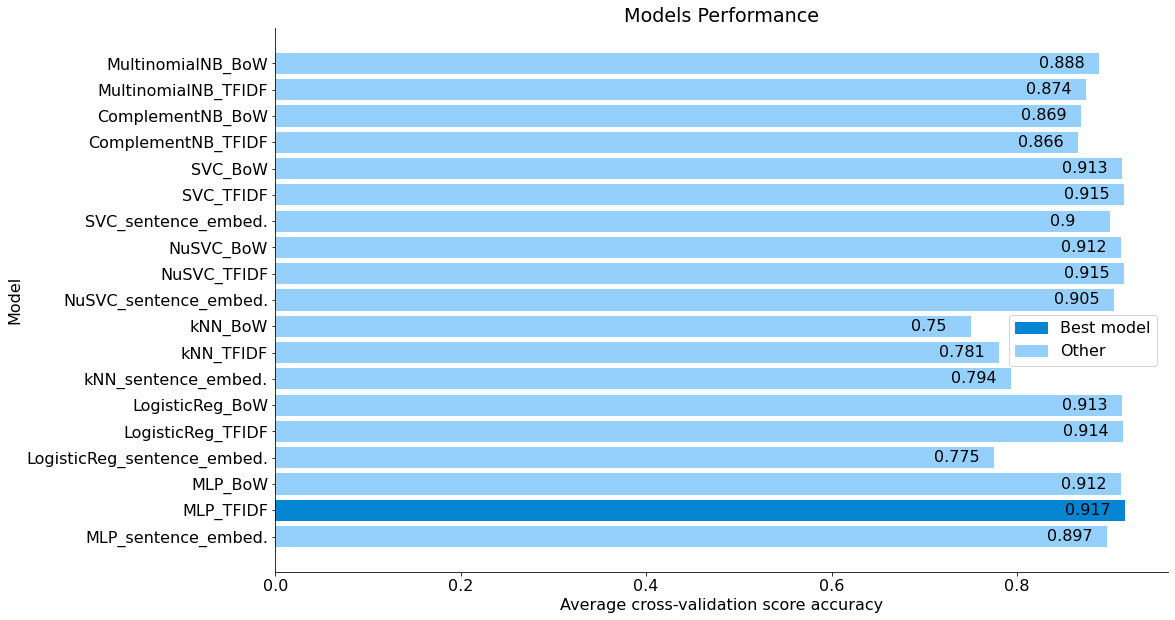

In [61]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

df = pd.DataFrame(data=d)

df['accuracy'] = round(df[['accuracy']], 3)

plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(16,10))

colors = ["xkcd:cerulean" if i == max(df['accuracy']) else "xkcd:light blue" for i in df['accuracy']]

ax.barh(df['model'], df['accuracy'], color=colors, align='center')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel("Average cross-validation score accuracy")
ax.set_title('Models Performance')
ax.bar_label(ax.containers[0], padding=-60) # label_type='edge', 
ax.set_ylabel("Model")

patch = mpatches.Patch(color='xkcd:cerulean', label='Best model')
patch2 = mpatches.Patch(color='xkcd:light blue', label='Other')
ax.legend(handles=[patch, patch2], bbox_to_anchor=(0.755, 0.4), bbox_transform=fig.transFigure)
#ax.legend(handles=[patch, patch2], loc='lower right')

ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False)

plt.savefig('../img/models_performance_mpnet.png', dpi=400, bbox_inches='tight', pad_inches=0)

plt.show()

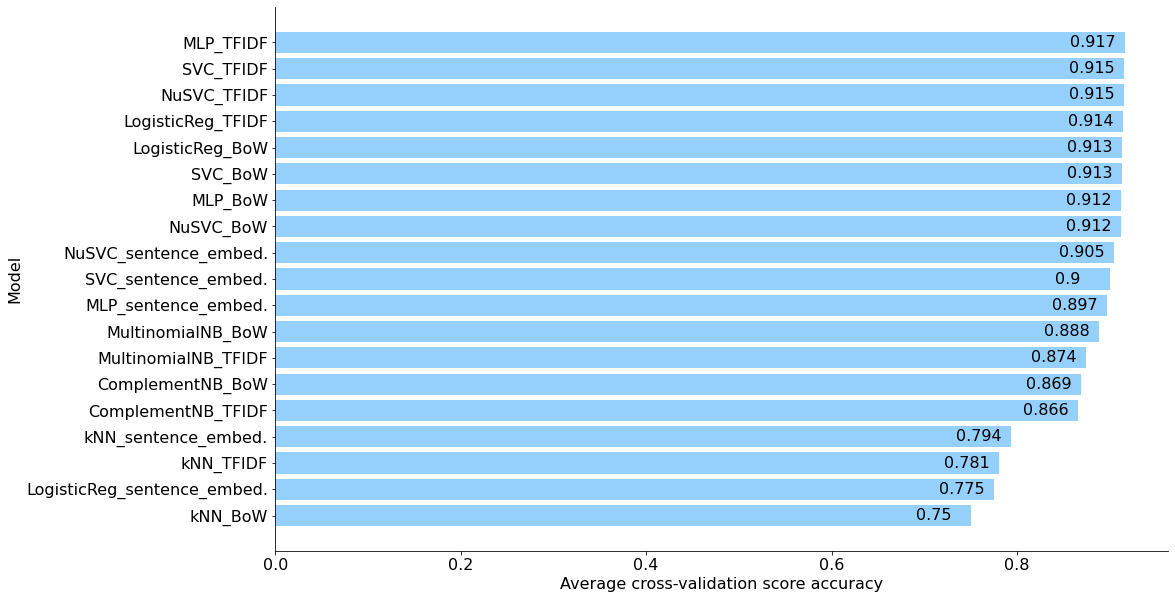

In [115]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

df = pd.DataFrame(data=d)

df['accuracy'] = round(df[['accuracy']], 3)

df = df.sort_values(by=['accuracy'], ascending=False)

plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(16,10))

#colors = ["xkcd:cerulean" if i == max(df['accuracy']) else "xkcd:light blue" for i in df['accuracy']]

ax.barh(df['model'], df['accuracy'], color='xkcd:light blue', align='center')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel("Average cross-validation score accuracy")
#ax.set_title('Models Performance')
ax.bar_label(ax.containers[0], padding=-55) # label_type='edge', 
ax.set_ylabel("Model")

ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False)

plt.savefig('../img/models_performance_mpnet_sorted.png', dpi=400, bbox_inches='tight', pad_inches=0)

plt.show()

# The best model

In [63]:
# MANUALLY pick the best performing model
model_svm = MLPClassifier(activation= 'logistic', alpha=0.01, random_state=RANDOM_STATE) #probability=True
# train your model on the entire training set
model_svm.fit(train_X_encodings_tfidf, y_train)

MLPClassifier(activation='logistic', alpha=0.01, random_state=42)

In [94]:
test_X_encodings_tfidf

<277x9715 sparse matrix of type '<class 'numpy.float64'>'
	with 18300 stored elements in Compressed Sparse Row format>

In [105]:
train_X_encodings_tfidf

<2880x9715 sparse matrix of type '<class 'numpy.float64'>'
	with 190786 stored elements in Compressed Sparse Row format>

In [64]:
# predict labels for the test set
y_pred = model_svm.predict(test_X_encodings_tfidf)

In [65]:
#print(classification_report(y_test, y_pred, labels=encoder_fitted.classes_))

In [66]:
accuracy_score(y_true=y_test, y_pred=y_pred)

0.3140794223826715

In [67]:
f1_score(y_true=y_test, y_pred=y_pred, average='macro')

0.14433484170271263

In [81]:
# on train set
y_pred_train = model_svm.predict(train_X_encodings_tfidf)
f1_score(y_true=y_train, y_pred=y_pred_train, average='macro')

0.9605678418074337

In [68]:
#pd.DataFrame(confusion_matrix(y_test, y_pred), index=encoder_fitted.classes_, columns=encoder_fitted.classes_)

In [69]:
# compute probabilities of possible outcomes for samples in X
y_score = model_svm.predict_proba(test_X_encodings_tfidf) # získáme pravděpodobnosti
y_score

array([[0.01099808, 0.02741635, 0.01390747, ..., 0.18720286, 0.11659709,
        0.04584991],
       [0.031017  , 0.02390204, 0.00599861, ..., 0.03216792, 0.01357117,
        0.07428985],
       [0.02846591, 0.05212446, 0.0127218 , ..., 0.02087426, 0.0403101 ,
        0.03823484],
       ...,
       [0.02570727, 0.01121162, 0.01362445, ..., 0.04732145, 0.01377767,
        0.22332486],
       [0.0531439 , 0.02711782, 0.01004584, ..., 0.02764932, 0.0178571 ,
        0.08922864],
       [0.01237675, 0.00638335, 0.00448323, ..., 0.01364207, 0.00754552,
        0.09619884]])

In [70]:
from sklearn.preprocessing import LabelBinarizer

class_bin = LabelBinarizer().fit(y_train)  # binarizace problemu
y_onehot_test = class_bin.transform(y_test)
y_onehot_test

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [71]:
class_bin.transform([4]) # topic 5 (je treba jeste dekodovat)

array([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]])

In [72]:
fpr, tpr, roc_auc = dict(), dict(), dict()

In [73]:
def count_micro(y_test, y_score):
    fpr['micro'], tpr['micro'], _ = roc_curve(y_test, y_score)  # _ thresholds, vraci body krivky definovane trp, fpr
    
    # secte plochu pod krivkou zadanou body
    roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])  # frp - x souradnice, trp - y souradnice

In [74]:
def count_macro(n_classes, y_test, y_score):
    # spocteme pro kazdou tridu auc zvlast
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i]) # one vs rest
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    fpr_grid = np.linspace(0.0, 1.0, 1000) # 1000 rovnomerne rozlozenych cisel mezi 0 a 1 
    mean_tpr = np.zeros_like(fpr_grid) # pole 0 o stejnem rozmeru jako fpr_frid
    
    for i in range(n_classes):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i]) 
        #fpr_grid - kde vyhodnotit hodnoty
        # fpr[i] - souradnice x bodu
        # tpr[i] - souradnice y bodu

    mean_tpr /= n_classes  # average
    
    fpr['macro'] = fpr_grid
    tpr['macro'] = mean_tpr
    roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

In [75]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

count_micro(y_onehot_test.ravel(), y_score.ravel())
count_macro(24, y_onehot_test, y_score)

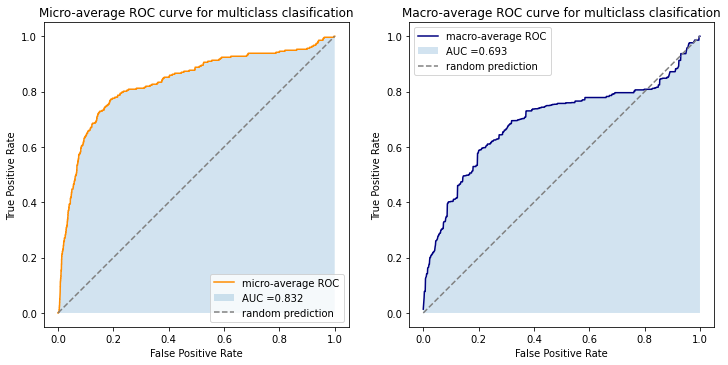

In [76]:
plt.rcParams.update({'font.size': 10})

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(
    fpr['micro'],
    tpr['micro'],
    label='micro-average ROC',
    color='darkorange',
)
ax[1].plot(
    fpr['macro'],
    tpr['macro'],
    label='macro-average ROC',
    color='navy',
)

ax[0].fill_between(fpr['micro'], tpr['micro'], alpha=0.2, label='AUC ={:.3f}'.format(roc_auc['micro']))
ax[1].fill_between(fpr['macro'], tpr['macro'], alpha=0.2, label='AUC ={:.3f}'.format(roc_auc['macro']))

for x in range(2):
    ax[x].axis('square')
    ax[x].set_xlabel('False Positive Rate')
    ax[x].set_ylabel('True Positive Rate')
    ax[x].plot([0, 1], [0, 1], "--", color = 'grey', label='random prediction')
    ax[x].legend()

ax[0].set_title(label='Micro-average ROC curve for multiclass clasification')
ax[1].set_title(label='Macro-average ROC curve for multiclass clasification')
plt.show()

In [77]:
# pozor, že jsme ty třídy kódovali
# původně ([ 1,  2,  3,  4,  9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])
# po kódování ([ 0, 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])

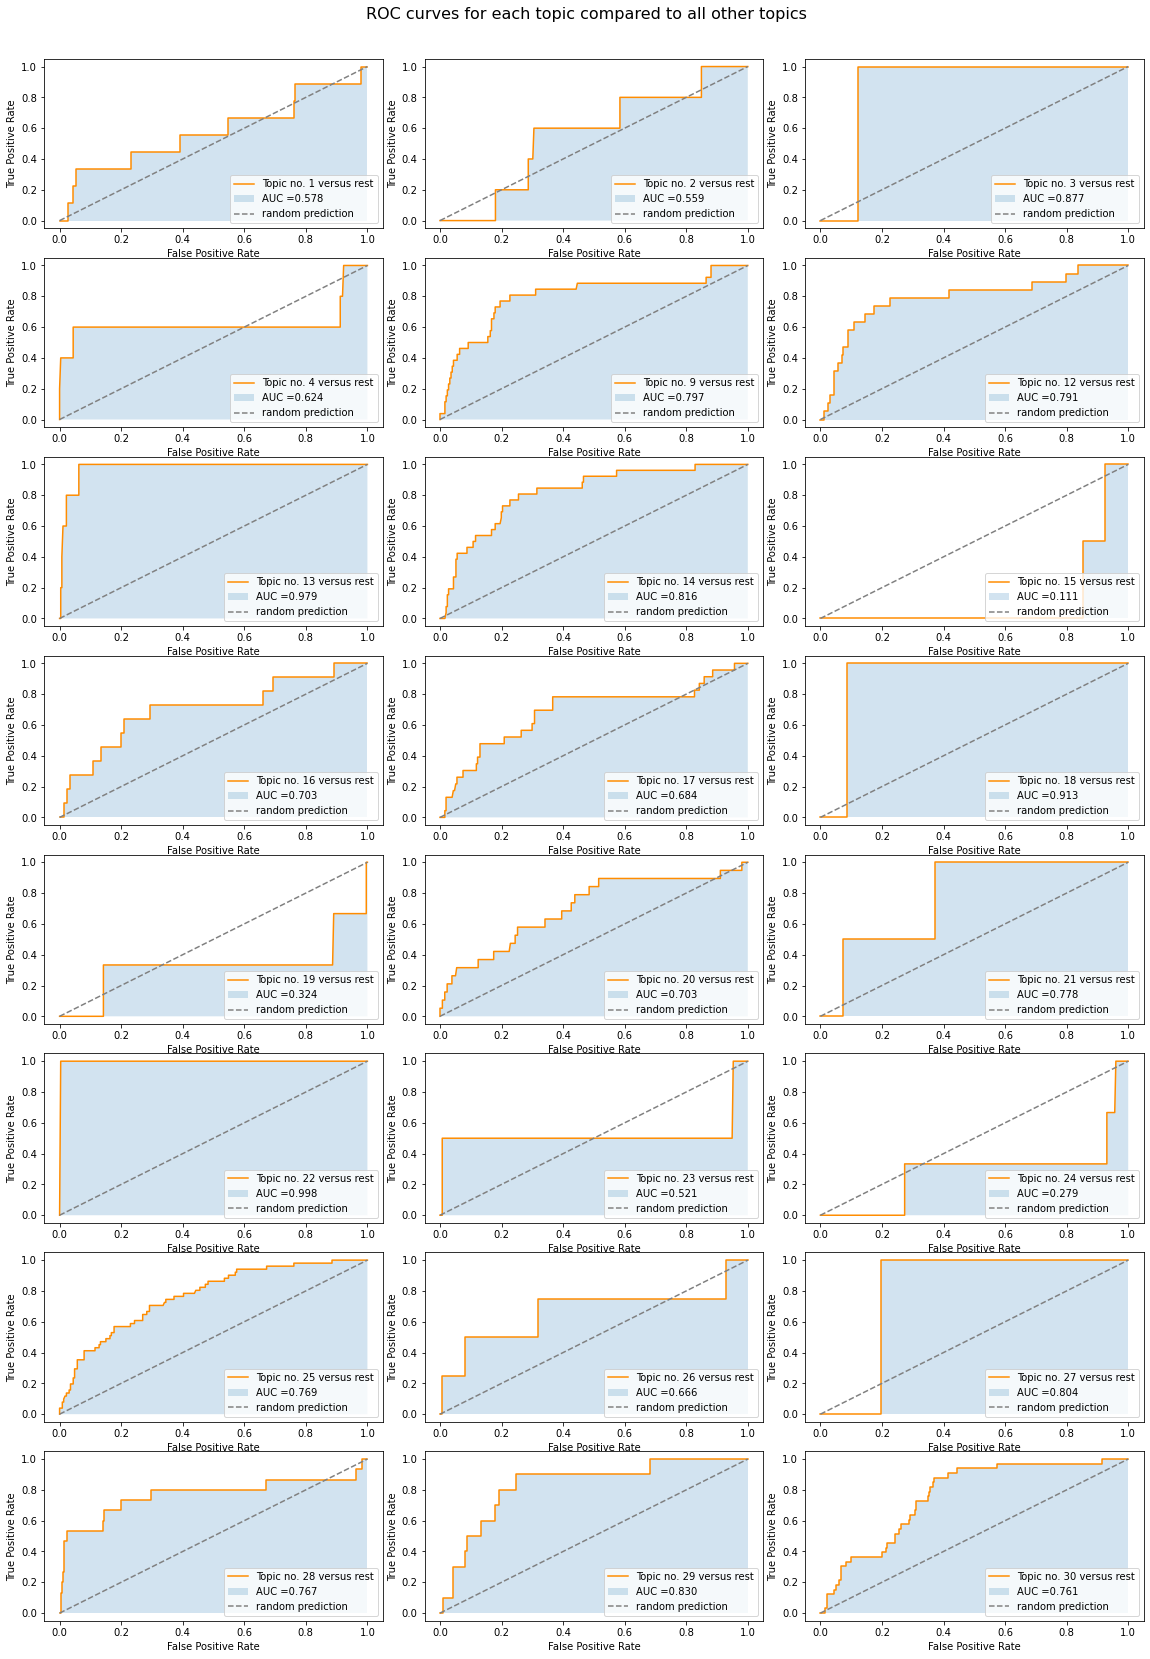

In [78]:
plt.rcParams.update({'font.size': 10})

fig, ax = plt.subplots(8, 3, figsize=(16, 24))
fig.tight_layout()

pos_x = 0
pos_y = 0

targets_origin = [1, 2, 3, 4, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

for x in range(24): # number of classes
    ax[pos_x, pos_y].plot(
    fpr[x],
    tpr[x],
    label=f'Topic no. {targets_origin[x]} versus rest', # start from topic 1 (indexovano od 1)
    color='darkorange',
    )
    ax[pos_x, pos_y].fill_between(fpr[x], tpr[x], alpha=0.2, label='AUC ={:.3f}'.format(roc_auc[x]))
    

    ax[pos_x, pos_y].set_xlabel('False Positive Rate')
    ax[pos_x, pos_y].set_ylabel('True Positive Rate')
    ax[pos_x, pos_y].plot([0, 1], [0, 1], "--", color = 'grey', label='random prediction')
    ax[pos_x, pos_y].legend(loc='lower right')
    

    pos_y += 1
    
    if pos_y == 3:
        pos_x += 1 
        pos_y = 0       

st = fig.suptitle('ROC curves for each topic compared to all other topics', fontsize=16)
# shift subplots down:
st.set_y(0.95)
fig.subplots_adjust(top=0.92)

plt.savefig('../img/ROC_each_topic_mpnet.png', dpi=400, bbox_inches='tight', pad_inches=0)

plt.show()

# Classify all poems

In [95]:
stopwords = ['mít', 'jít', 'být', 'dát', 'moci']

In [96]:
%%time

lemmas_filtered_column = []

# extract lemmas with N, A or V POS tag
for index, poem in lemmas.iterrows():
    if index % 1000 == 0:
        print(index, end=' ')
    
    lemmas_filtered_poem = []
    lemmas_poem = literal_eval(poem['lemmas'])
    for lemma_pos in lemmas_poem:
        lemma, pos = lemma_pos
        if pos in ['N', 'A', 'V'] and lemma not in stopwords:
            lemmas_filtered_poem.append(lemma)
    lemmas_filtered_column.append(lemmas_filtered_poem)

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 CPU times: user 2min 36s, sys: 2.09 s, total: 2min 38s
Wall time: 2min 40s


In [97]:
lemmas['lemmas_filtered'] = lemmas_filtered_column

In [98]:
min_frequency = 20

In [99]:
dictionary = Dictionary(lemmas['lemmas_filtered'])

In [100]:
# Filter out words
dictionary.filter_extremes(no_below=min_frequency)

In [101]:
lemmas['text_preprocessed'] = lemmas['lemmas_filtered'].apply(lambda x: ' '.join(x))

In [102]:
vectorizer_tfidf = TfidfVectorizer()

vectorizer_tfidf.fit(lemmas['text_preprocessed'])

# Transform your text data into a matrix of token counts
encodings_tfidf = vectorizer_tfidf.transform(lemmas['text_preprocessed'])

In [104]:
encodings_tfidf

<66428x64332 sparse matrix of type '<class 'numpy.float64'>'
	with 4966189 stored elements in Compressed Sparse Row format>

In [ ]:
# predict labels for the all data
predicted_labels = model_svm.predict(encodings_tfidf)

In [ ]:
len(predicted_labels)

In [ ]:
lemmas['predicted_label'] = predicted_labels

In [ ]:
mapping = dict(zip(encoder_fitted.transform(encoder_fitted.classes_), encoder_fitted.classes_))

In [ ]:
lemmas.predicted_label.replace(mapping, inplace=True)

In [ ]:
lemmas

In [ ]:
labels_lemmas = pd.merge(lemmas, annotations_lemmas, on='book_poem_id', how='left')